## <font color="red">Aprendendo representações com Deep Learning: arquiteturas, treinamento e transferência de aprendizado</font>
#### **IV Escola Avançada em Big Data Analysis**
#### *ICMC - Universidade de São Paulo*

Moacir A. Ponti

---

### Long Short Term Memory network (LSTM)

---

(144,)


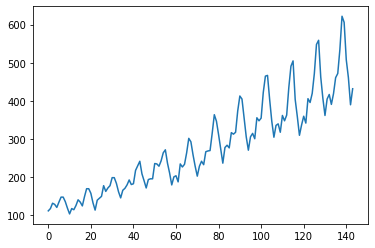

In [1]:
import numpy as np
from pandas import read_csv
from pandas import datetime

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from numpy.random import seed
from tensorflow.random import set_seed

from sklearn.metrics import mean_squared_error
from math import sqrt

df = read_csv('passengers.csv')

series = np.array(df['n_pass_thousands'])
plt.plot(series)
print(series.shape)

Treinamento:  (120,)
Teste:  (24,)


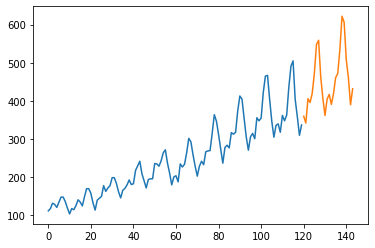

In [2]:
# divide dados de treinamento e teste
train, test = series[0:-24], series[-24:]

print("Treinamento: ", train.shape)
print("Teste: ", test.shape)
plt.plot(np.arange(0, 120), train)
plt.plot(np.arange(120,144), test)

### Parte 1: Preparando os dados

#### a) Problema de aprendizado supervisionado
Podemos cumprir essa etapa utilizando a observação do último passo $t-1$ como entrada e a observação atual $t$ como saída.

Podemos alcançar isso empurrando todos os valores da série por um número específico de posições. Aqui vamos deslocar 1 posição para trás, que se tornarão as variáveis de entrada, sendo que a série temporal original será considerada como a variável de saída.

#### b) Normalização

Redes neurais não funcionam bem com dados não normalizados. Aqui utilizaremos a normalização Min-Max para 0-1


In [3]:
# modifica uma serie temporal tornando-a
# um problema de aprendizado supervisionado
def timeseries_to_supervised(series, look_back=1):
  x = series[:-look_back]
  y = np.array(series[look_back:], copy=True)
  return x,y

def normalize(train, test):
    d_max = np.max(train)
    d_min = np.min(train)		
    return ((train - d_min) / (d_max-d_min)), ((test - d_min) / (d_max-d_min))

In [4]:
look_back = 1

n_train, n_test = normalize(train, test)

x_train, y_train = timeseries_to_supervised(n_train, look_back)
x_test, y_test = timeseries_to_supervised(n_test, look_back)

#mostrando exemplos
print(x_train[:4])
print(y_train[:4])
print("Dados treinamento: ", x_train.shape)
print("Dados teste: ", x_test.shape)

n1 = x_train.shape[0]
n2 = x_test.shape[0]

[0.01995012 0.03491272 0.06982544 0.06234414]
[0.03491272 0.06982544 0.06234414 0.04239401]
Dados treinamento:  (119,)
Dados teste:  (23,)


## Utilizando unidades Densas para predição

Vamos tentar aprender a partir da série para obter um tipo de regressão

In [5]:
MLP = keras.Sequential()
MLP.add(keras.layers.Dense(16, input_shape=(1,)))
MLP.add(keras.layers.Dense(1))

In [6]:
seed(1)
set_seed(1)

batch_size = 1
epochs = 50
MLP.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=0.001))
histMLP = MLP.fit(x_train, y_train,  batch_size=batch_size, epochs=epochs, verbose=0)

In [7]:
# make predictions
mlpTrain = MLP.predict(x_train)
mlpTest = MLP.predict(x_test)

print(mlpTrain[:4])

[[0.03413953]
 [0.048232  ]
 [0.08111446]
 [0.07406823]]


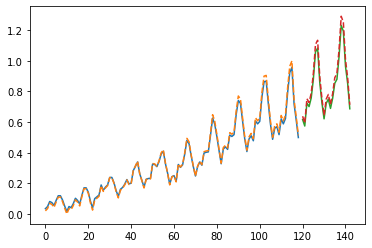

In [8]:
plt.plot(mlpTrain)
plt.plot(x_train,'--')

plt.plot(np.arange(120,120+n2), mlpTest)
plt.plot(np.arange(120,120+n2), x_test,'--')

In [9]:
score = MLP.evaluate(x_test, y_test, verbose=0)
print(score)

0.018041763454675674


## Utilizando LSTMs para predição

Agora utilizaremos uma rede neural baseada em camada recorrente, permitindo aprender a sequência.

Uma camada LSTM espera como entrada uma matriz com as seguintes dimensões:

samples x time_steps x features

* *Samples* são as observações independentes do domínio, tipicamente colunas de dados, consideradas no batch

* *Time steps* são os passos temporais separados de uma dada variável para uma dada observação - quantas observações serão dadas como entrada antes de que a primeira saída seja obtida

* *Features* são as medidas separadas observada em cada tempo da observação - quantos valores são considerados em cada entrada

No caso dessa base de dados, podemos usar diferentes configurações. Para manter simples, consideramos que o problema em cada passo de tempo é uma amostra individual, com um time step e uma feature apenas.


In [10]:
# formato deve ser [samples, time steps, features]
lstm_train = np.reshape(x_train, (x_train.shape[0], 1, 1))
lstm_test = np.reshape(x_test, (x_test.shape[0], 1, 1))
print(lstm_train[:4])
print(lstm_train.shape)

[[[0.01995012]]

 [[0.03491272]]

 [[0.06982544]]

 [[0.06234414]]]
(119, 1, 1)


## Rede LSTM

Definimos o número de neurônios, ou seja a quantidade de unidades de memória, ex. 1 a 5.

In [11]:
neurons = 4
batch_size = 1

model = keras.models.Sequential()
model.add(keras.layers.LSTM(neurons, input_shape=(1,1)))
model.add(keras.layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4)                 96        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [12]:
seed(1)
set_seed(1)
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=0.001))

model.fit(lstm_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)

In [13]:
# realiza predicoes
lstmTrain = model.predict(lstm_train)
lstmTest = model.predict(lstm_test)

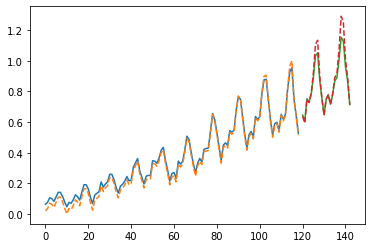

In [14]:
plt.plot(lstmTrain)
plt.plot(x_train,'--')

plt.plot(np.arange(120,120+n2), lstmTest)
plt.plot(np.arange(120,120+n2), x_test,'--')

In [15]:
scoreLSTM = model.evaluate(lstm_test, y_test, verbose=0)
print("Perda LSTM: %.5f" % (scoreLSTM))
scoreMLP = MLP.evaluate(x_test, y_test, verbose=0)
print("Perda MLP: %.5f" % (scoreMLP))

Perda LSTM: 0.01594
Perda MLP: 0.01804
